In [1]:
# Dependencies
import os
import random
import numpy as np

import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.distributions import Uniform, Normal, Categorical

import matplotlib.pyplot as plt

In [2]:
# Loading the data
joint_probs = th.Tensor( np.load( os.path.join( "", './distribution.npy')))
# Flattening the joint prob to 1D. Each pair of x_1, x_2 is materialized by a single z,
# which is affected with the respective joint probability distribution
joint_probs = joint_probs.view((200*200))
# Creating the z Categorical distribution
z_dist = th.distributions.categorical.Categorical( probs=joint_probs)
z_samples = z_dist.sample( [int( 1e5)])
full_data = []
# Sampling z and creating fulldata with pairs
for z in z_samples:
    full_data.append( (z // 200, z % 200))

# Data set subdivision train/test
full_data = np.array( full_data)

# Precomputing some static data for downstream visualization
# Namely used for debug to check that p(x_1) and p(x_2|x_1) are properly estimated
x1s_counters = { i: 0 for i in range(200)}
for x1 in full_data[:,0]:
            x1s_counters[x1]+= 1

x2s_counters = { i: 0 for i in range(200)}
for x2 in full_data[:,1]:
            x2s_counters[x2]+= 1

x1_histogram = np.array( [ x1s_counters[i] / len( full_data) for i in range( 200)])
x2_histogram = np.array( [ x2s_counters[i] / len( full_data) for i in range( 200)])

In [3]:
# Hyper parameters
SEED = 0
N_EPOCHS = 20
LR = 1e-3
BATCH_SIZE = 100

HIDDEN_SIZES = [784]
LATENT_DIM = HIDDEN_SIZES[-1]

INPUT_ORDERINGS = 0
 # Input ordering meaning
# -1: Generate a new input ordering every time it is needed. Not realistic, maybe on infinimum computer ...
#  0: Natural Order ,default for this exercise.
#  1: A single input ordering but shuffled
#  2..:

CONNECTIVITY_ORDERINGS = 1
# connectivity Orderings
# -1: Generate new masks everytime. Unrealistic
#  0: # TODO: Use no mask == classical AE
#  1..: Use specified amount of randomly generated masks.

RESAMPLE_INTERVAL = 20

USE_GPU=True
device = th.device( "cuda" if th.cuda.is_available()and USE_GPU else "cpu")

# Shuffle data
SHUFFLE_DATA = True

# Seeding
random.seed(SEED)
np.random.seed( SEED)

# Pytorch seeding
th.manual_seed( SEED)
if device.type == "cuda":
    th.cuda.manual_seed_all(SEED)

In [4]:
# Dataloader to ease the pain
def shuffle_dataset():
    np.random.shuffle(full_data)

    train_ds = full_data[:int(.8*len( full_data))]
    test_ds = full_data[int(.8*len( full_data)):]

    trainset = th.utils.data.DataLoader( train_ds, batch_size=BATCH_SIZE, shuffle=True)
    testset = th.utils.data.DataLoader( test_ds, batch_size=len(test_ds), shuffle=False)
    
    return trainset, testset # Just return the full test_batch directly.

trainset, testset = shuffle_dataset()

In [5]:
# DEBUG What is the data ? Our lord and savior Sir Alan Turing !
# plt.hist2d( test_ds[:,0], test_ds[:,1], bins=(200,200), cmap='gist_gray')
# plt.hist2d( train_ds[:,0], train_ds[:,1], bins=(200,200), cmap='gist_gray')
# The fewer the samples, the lower the image's "resolution"

# plt.hist2d( full_data[:,0], full_data[:,1], bins=(200,200), cmap='gist_gray') # Best resolution
# plt.show()

# print( train_ds.shape)
# print( test_ds.shape)

In [6]:
# Model definition
INPUT_DIM = 2
N_CLASSES = 200 # Used to tranform the inputs into one-hot vectors
OUTPUT_DIM = INPUT_DIM * N_CLASSES # We aim at having the prob dist for each x1 and x2 component...

class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', th.ones(out_features, in_features))
    
    def set_mask(self, mask):
        self.mask.data.copy_(th.from_numpy(mask.astype(np.uint8).T))
    
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

class EncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Dynamic generating of mask and orderings for efficiency
        self.connectivity_ordering_seed = 0 # TODO: 0 + SEED ?
        self.input_ordering_seed = 0

        # Pay attention to the "s"
        self.connectivity_orderings = CONNECTIVITY_ORDERINGS
        self.input_orderings = INPUT_ORDERINGS

        # MLP Layers
        self.encoder_layers = nn.ModuleList()
        self.decoder_layers = nn.ModuleList()
        
        # Hidden sizes presistent
        self.encoder_hiddens = HIDDEN_SIZES
        self.decoder_hiddens = HIDDEN_SIZES[::-1][1:]
        self.decoder_hiddens.append(OUTPUT_DIM)

        # This define d for each component of the input vector
        # Since we are using the one hot input format, we need to adjust the layer connectivity ordering
        self.input_ordering = []
        for i in range(1,INPUT_DIM+1):
            for _ in range(N_CLASSES):
                self.input_ordering.append(i)
        
        current_dim = INPUT_DIM * N_CLASSES
        current_input_orders = self.input_ordering # (m_l in the paper)
        
        ## Encoder layers
        for hsize in self.encoder_hiddens:
            # Linear layer with weights and biases included
            self.encoder_layers.append( MaskedLinear(current_dim, hsize))
            current_dim = hsize

        ## Decoder layers
        for hsize in self.decoder_hiddens:
            # Linear layer with weights and biases included
            self.decoder_layers.append( MaskedLinear(current_dim, hsize))
            current_dim = hsize

        # Note: not used in this exercise, since we explicitly need p(x_2|x_1)
        if self.input_orderings == 1:
            np.random.shuffle(self.input_ordering)

        # Lets us know if the mask was generated at least once already, for efficiency when using a single connectivity ordering
        self.mask_generated = False
        
        self.generate_masks()

    def shuffle_input_ordering(self):
        # Totally random input ordeing generation. Quite unstable
        if self.input_orderings == -1:
            random.shuffle(self.input_ordering)

        if self.input_orderings in [0,1]:
            pass # Using natural order

        elif self.input_orderings > 1:
            rng = np.random.RandomState(self.input_ordering_seed)

            self.input_ordering = rng.randint(1, INPUT_DIM+1, INPUT_DIM)
            self.input_ordering_seed = (self.input_ordering_seed + 1) % self.input_orderings
        else:
            raise NotImplementedError

    def generate_masks(self):
        if self.mask_generated and self.connectivity_orderings == 1:
            return # Skips mask generation for efficiciency
        
        if self.connectivity_orderings == -1:
            raise NotImplementedError
        
        elif self.connectivity_orderings == 0:
            # Standard VAE
            for hsize in self.encoder_hiddens:
                self.encoder_masks.append(None)
                
            for hsize in self.decoder_hiddens:
                self.decoder_masks.append(None)
            
            return 
        elif self.connectivity_orderings >=1:
            # TODO: Skip generation if using only one mask for efficiency
            # Inspired from Andrej Karpathy's implementation. Props where due.
            rng = np.random.RandomState(self.connectivity_ordering_seed)
            self.connectivity_ordering_seed = (self.connectivity_ordering_seed + 1) % self.connectivity_orderings

        else:
            raise NotImplementedError

        current_dim = INPUT_DIM * N_CLASSES
        current_input_orders = self.input_ordering # (m_l in the paper)

        layer_connect_counts = []

        for layer_idx, hsize in enumerate(self.encoder_hiddens):
            # Fix #1: Make sure we do not sample connectivity count that are not in the previous layer,
            # since they won't be useful, and reduce the number of weights that are actually used for the esitmation            
            layer_count_low = 1 if len(layer_connect_counts) == 0 else np.min(layer_connect_counts)
            layer_connect_counts = [rng.randint(low=layer_count_low,high=INPUT_DIM) for _ in range(hsize)]

            # Generating a mask for each layer and storing it
            mask = [[ 1 if layer_connect_counts[k] >= d else 0 for k in range(hsize)] for d in current_input_orders]
            self.encoder_layers[layer_idx].set_mask(np.array(mask))

            current_dim = hsize
            current_input_orders = layer_connect_counts

        # Decoder subsection
        for layer_idx, hsize in enumerate(self.decoder_hiddens):
            if layer_idx == len(self.decoder_hiddens)-1:
                layer_connect_counts = self.input_ordering
                mask = [[ 1 if layer_connect_counts[k] > d else 0 for k in range(hsize)] for d in current_input_orders]
            else:
                # Note: In case we did not reach the last layer, we still generate the mask as for the
                # encoder's layer ! That was the problem we were having ...
                layer_count_low = 1 if len(layer_connect_counts) == 0 else np.min(layer_connect_counts)
                layer_connect_counts = [rng.randint(low=layer_count_low,high=INPUT_DIM) for _ in range(hsize)]

                # Generating a mask for each layer and storing it
                mask = [[ 1 if layer_connect_counts[k] >= d else 0 for k in range(hsize)] for d in current_input_orders]
            
            self.decoder_layers[layer_idx].set_mask(np.array(mask))

            current_dim = hsize
            current_input_orders = layer_connect_counts

    def encode(self,x):
        for layer in self.encoder_layers:
            x = F.relu(layer(x))
        return x

    def decode(self,z):
        for layer in self.decoder_layers[:-1]:
            z = F.relu(layer(z))

        z = self.decoder_layers[-1](z)

        x1_logits = z[:, :N_CLASSES]
        x2_logits = z[:, N_CLASSES:]
        
        return x1_logits, x2_logits

    def forward(self,x):
        return self.decode(self.encode(x))

# Instanciating the model
encdec = EncoderDecoder().to(device)
print(encdec) # DEBUG

# Optimizer
optimiza = optim.Adam(list(encdec.parameters()), lr=LR)

EncoderDecoder(
  (encoder_layers): ModuleList(
    (0): MaskedLinear(in_features=400, out_features=784, bias=True)
  )
  (decoder_layers): ModuleList(
    (0): MaskedLinear(in_features=784, out_features=400, bias=True)
  )
)


In [7]:
# Helper to compute loss function
def compute_loss(model, data):
    x1s = data[:,0]
    x2s = data[:,1]
    
    x1s_hot = F.one_hot(x1s, N_CLASSES).float()
    x2s_hot = F.one_hot(x2s, N_CLASSES).float()
    data = th.cat([x1s_hot,x2s_hot], 1)
    
    z = model.encode(data)
    
    x1_logits, x2_logits = model.decode(z)
    
    x1_loss = F.cross_entropy(x1_logits, x1s)
    x2_loss = F.cross_entropy(x2_logits, x2s)
    loss = x1_loss + x2_loss
    
    return loss, z.detach()

def compute_test_loss(model, testset):
    loss = 0.
    for test_batch_idx, test_batch in enumerate(testset):
        batch_loss, _ = compute_loss(model, test_batch.to(device))
        loss += batch_loss
    
    loss /= (test_batch_idx+1)
    
    return loss

Epoch 0 (Last MB Loss)
	 Train Loss : 10.5820 , Test Loss: 10.5517
Epoch 1 (Last MB Loss)
	 Train Loss : 10.5558 , Test Loss: 10.5214


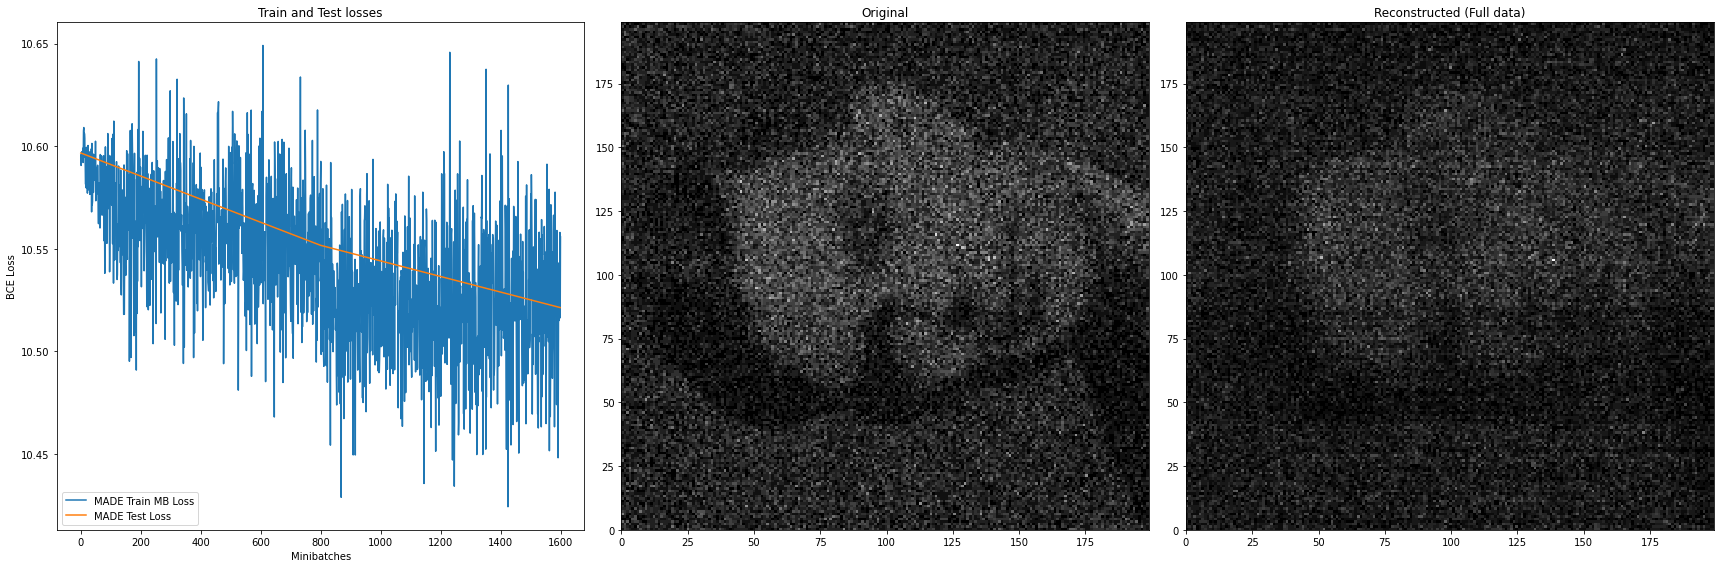

Epoch 2 (Last MB Loss)
	 Train Loss : 10.4776 , Test Loss: 10.4952


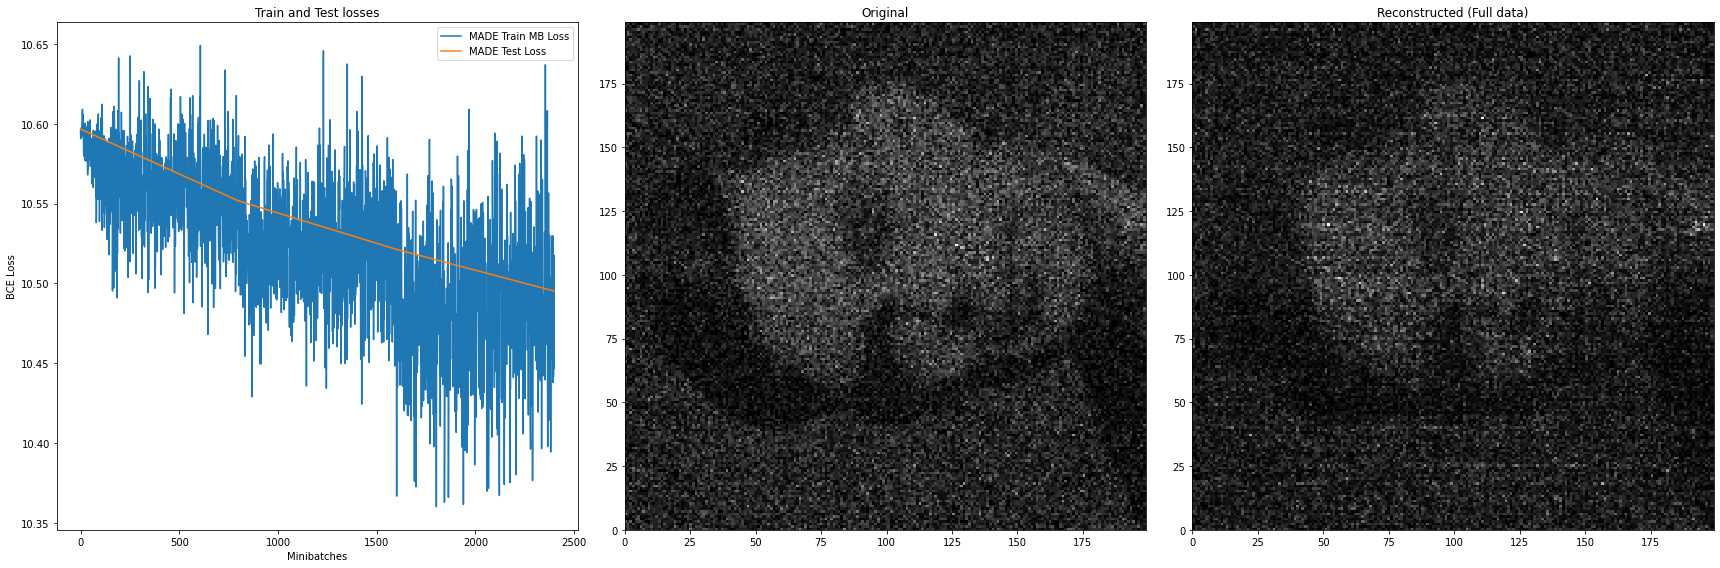

Epoch 3 (Last MB Loss)
	 Train Loss : 10.4312 , Test Loss: 10.4709


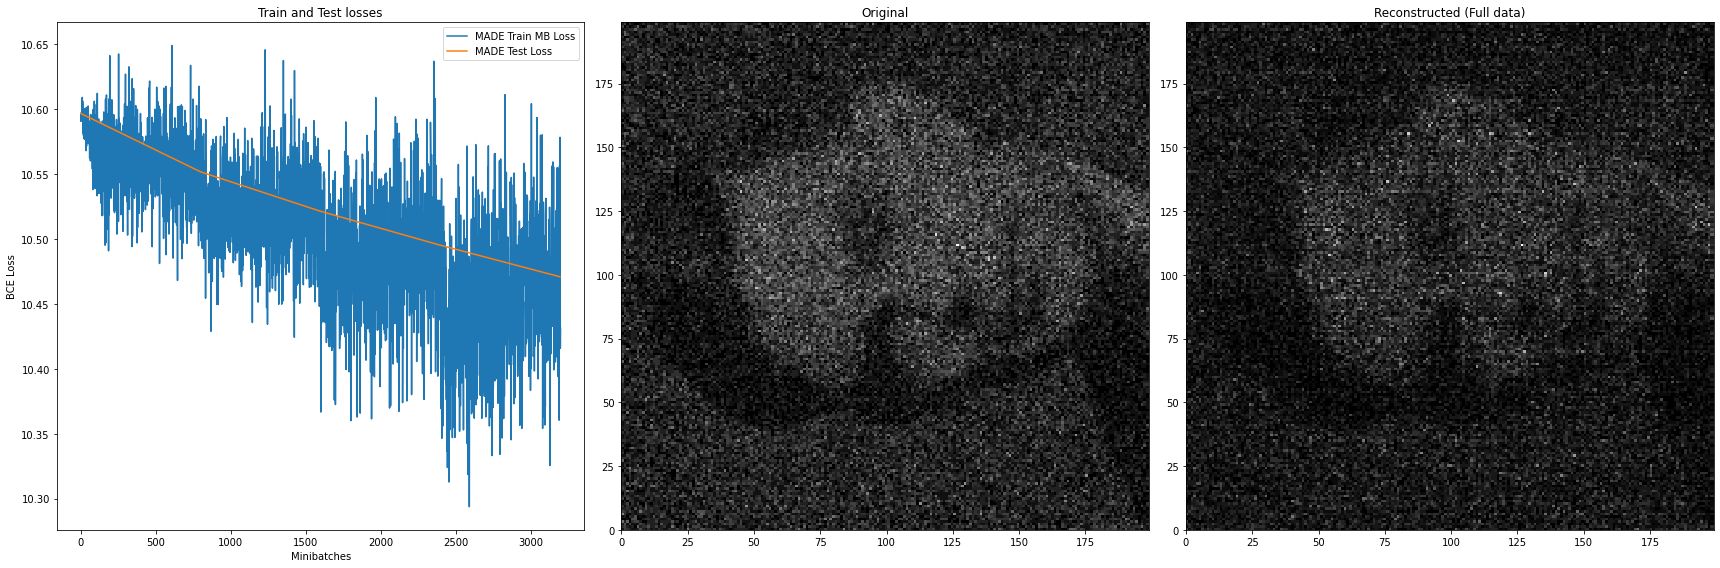

Epoch 4 (Last MB Loss)
	 Train Loss : 10.4056 , Test Loss: 10.4617


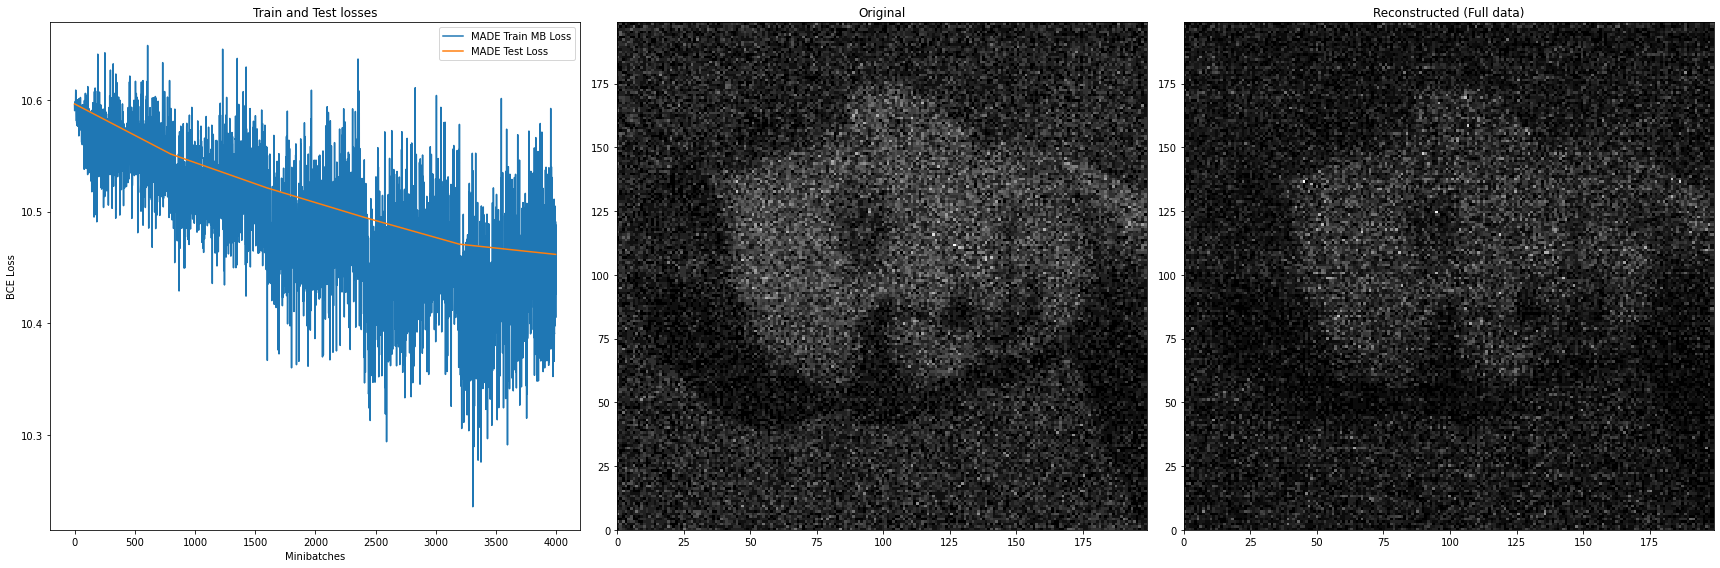

Epoch 5 (Last MB Loss)
	 Train Loss : 10.3949 , Test Loss: 10.4439


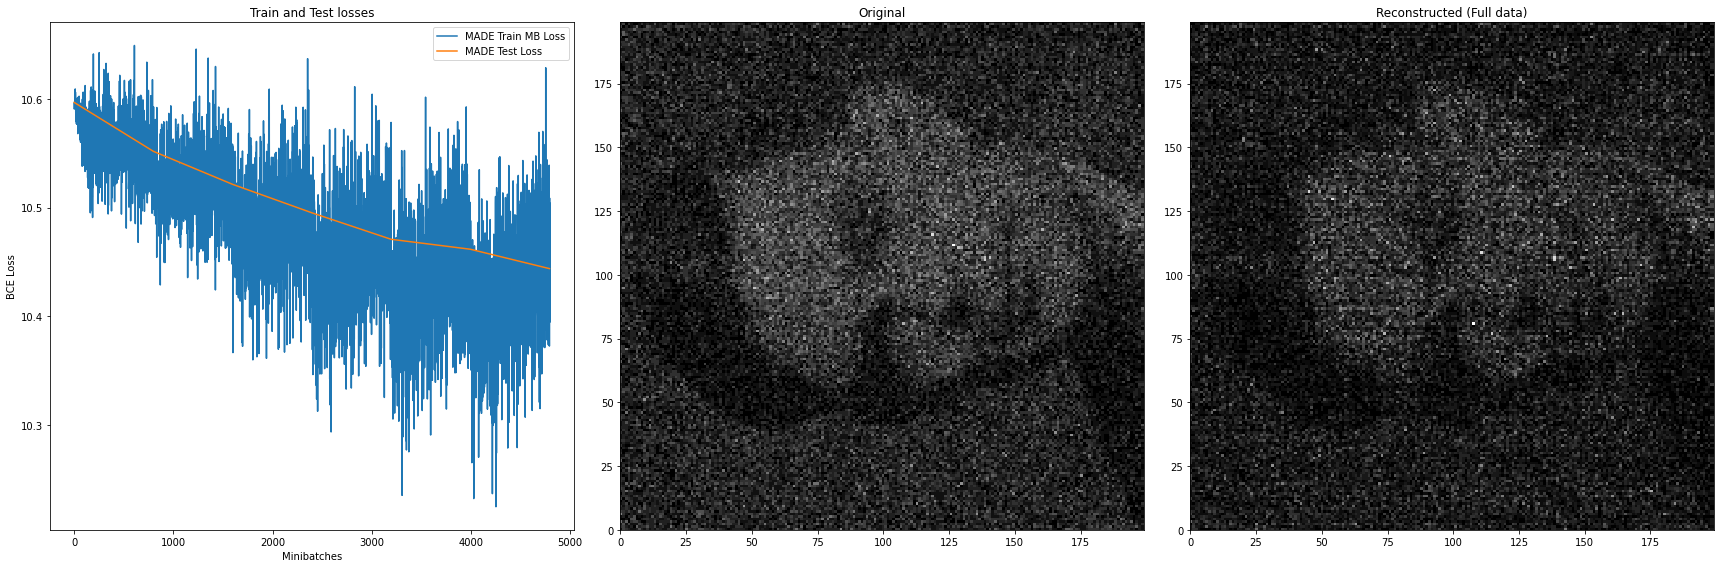

Epoch 6 (Last MB Loss)
	 Train Loss : 10.4053 , Test Loss: 10.4454


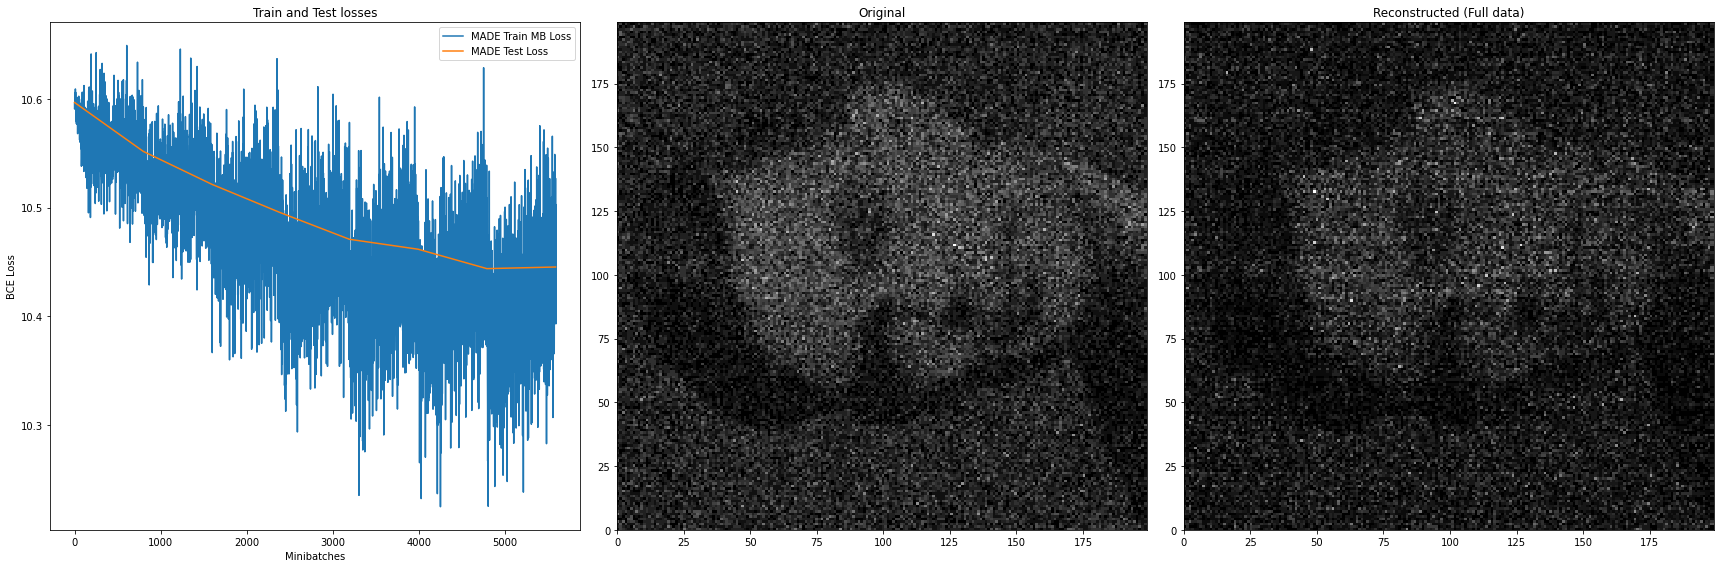

Epoch 7 (Last MB Loss)
	 Train Loss : 10.3897 , Test Loss: 10.4292


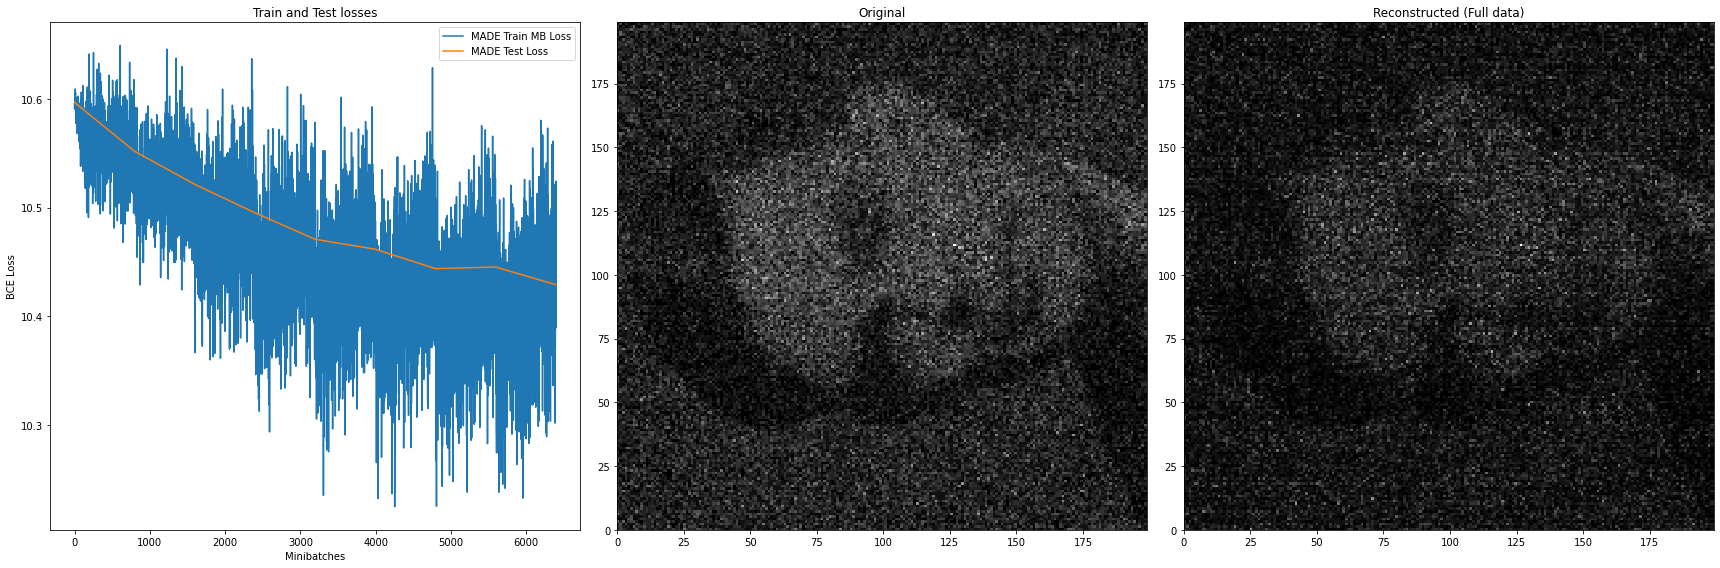

Epoch 8 (Last MB Loss)
	 Train Loss : 10.4174 , Test Loss: 10.4301


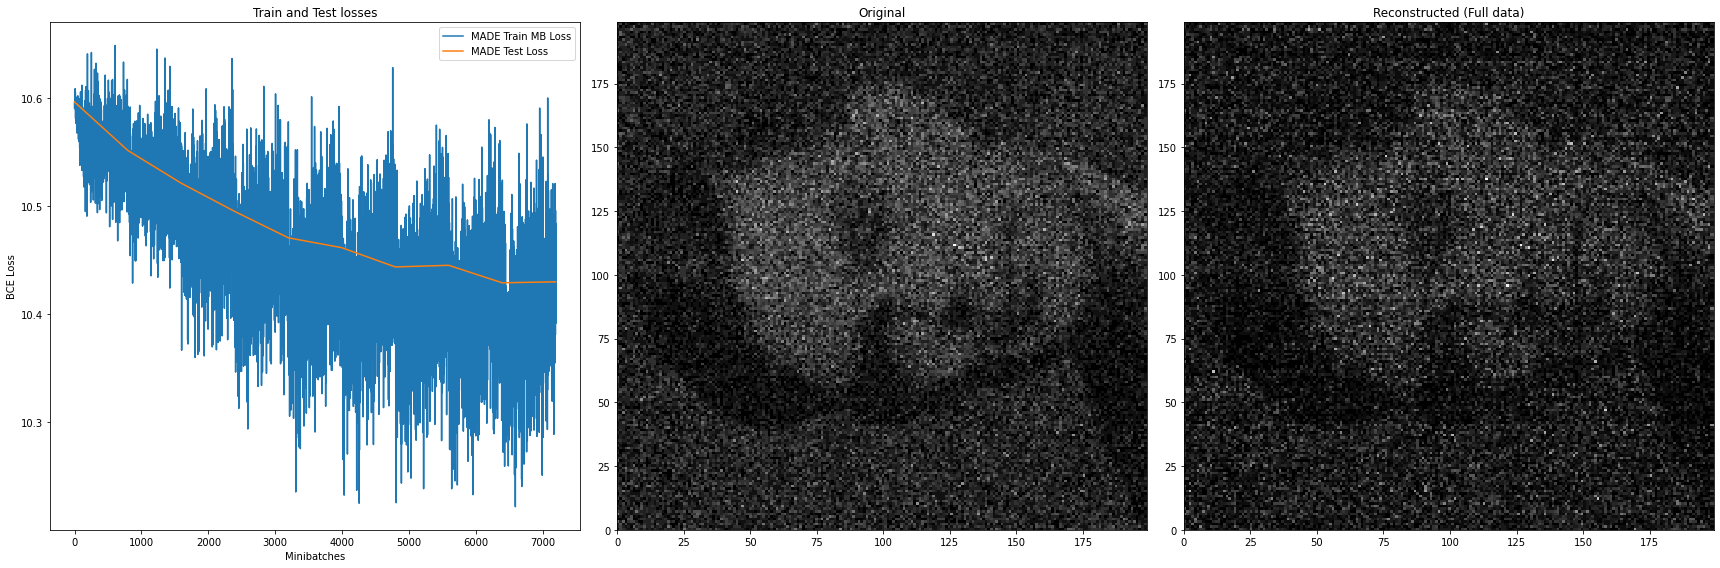

Epoch 9 (Last MB Loss)
	 Train Loss : 10.4098 , Test Loss: 10.4274


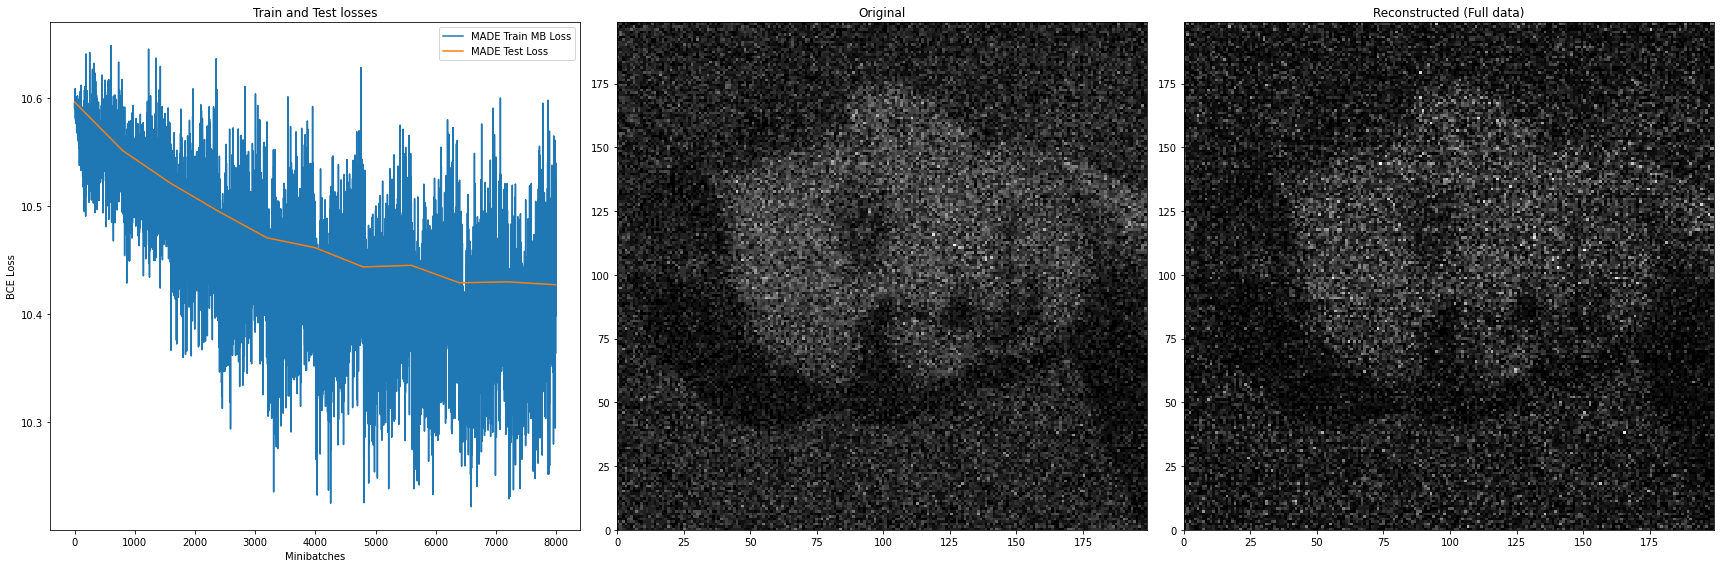

Epoch 10 (Last MB Loss)
	 Train Loss : 10.4209 , Test Loss: 10.4262


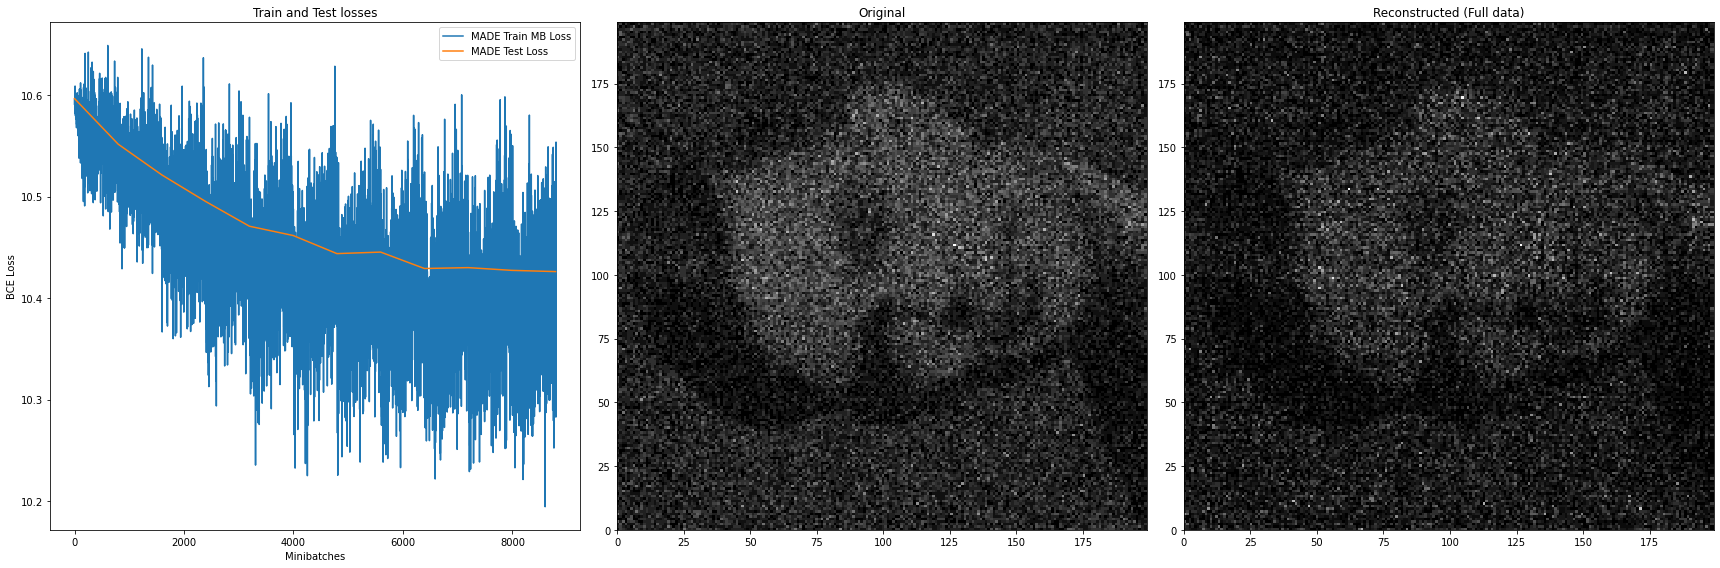

Epoch 11 (Last MB Loss)
	 Train Loss : 10.3631 , Test Loss: 10.4212


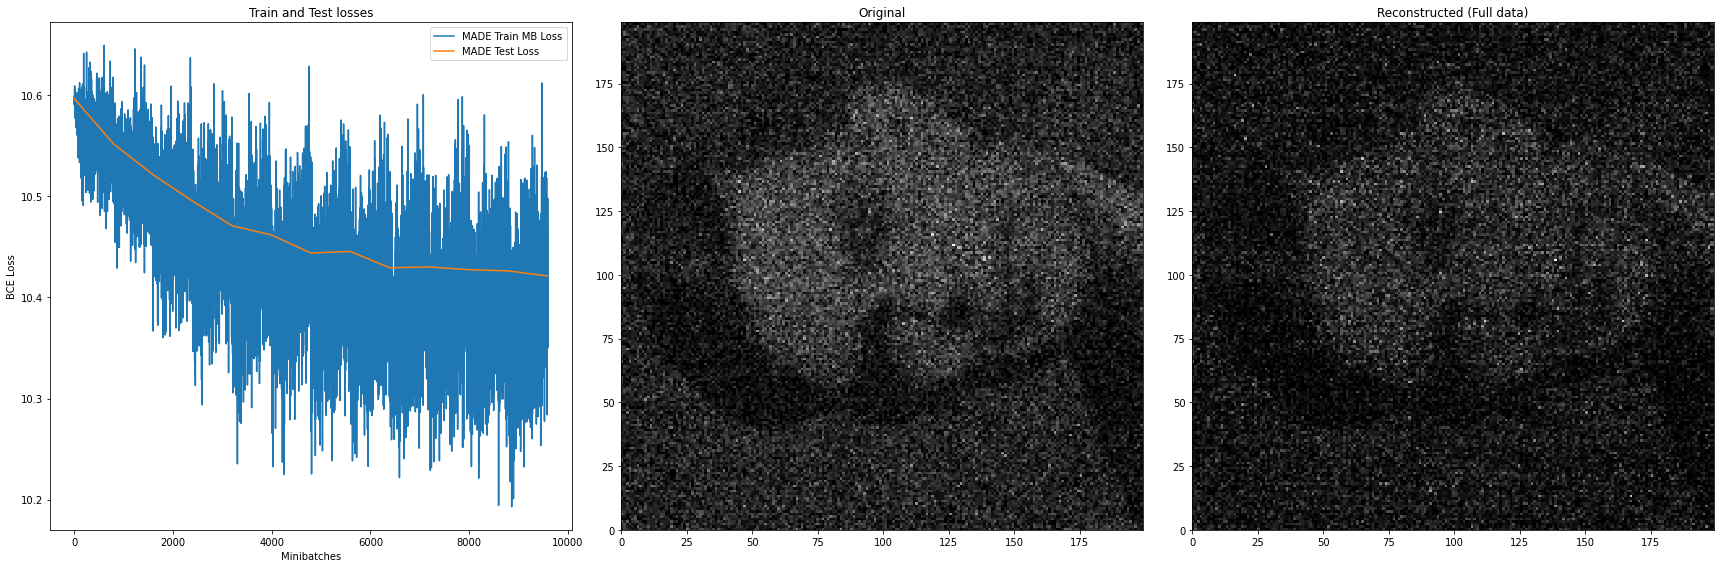

Epoch 12 (Last MB Loss)
	 Train Loss : 10.3630 , Test Loss: 10.4158


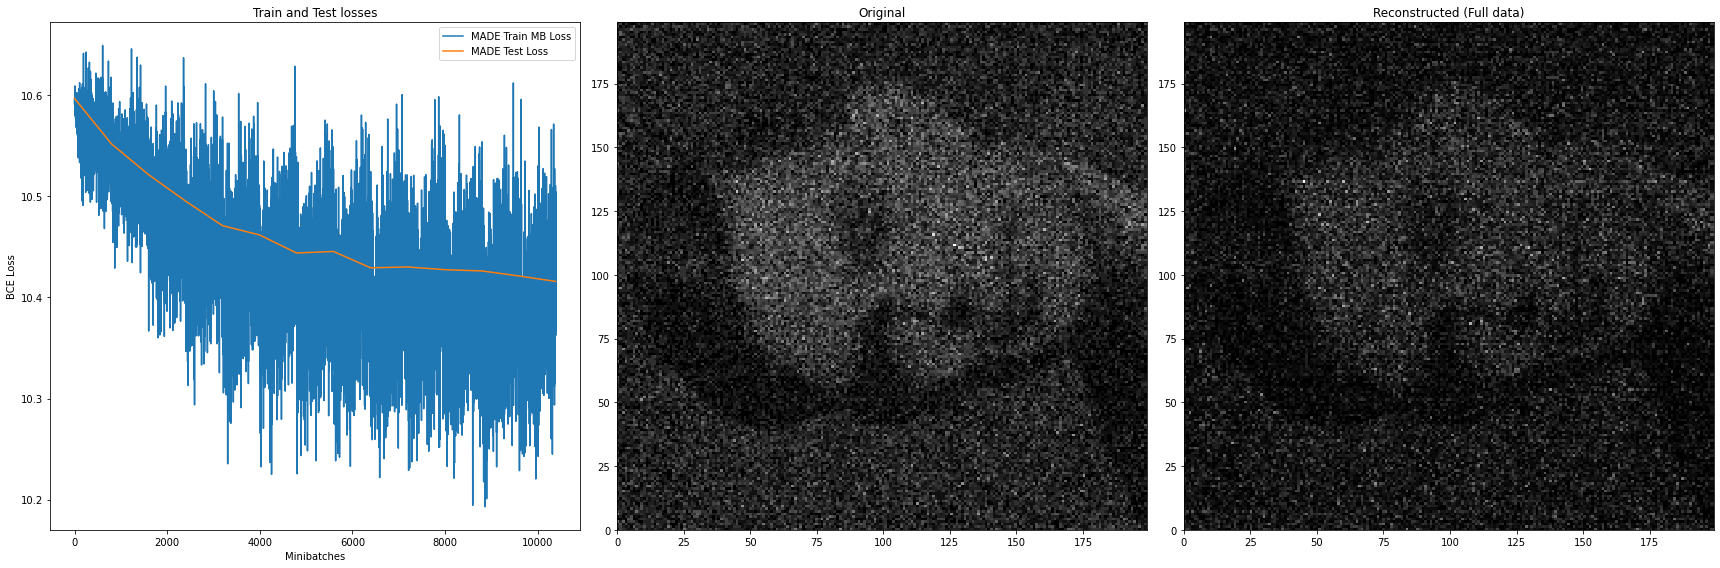

Epoch 13 (Last MB Loss)
	 Train Loss : 10.4333 , Test Loss: 10.4151


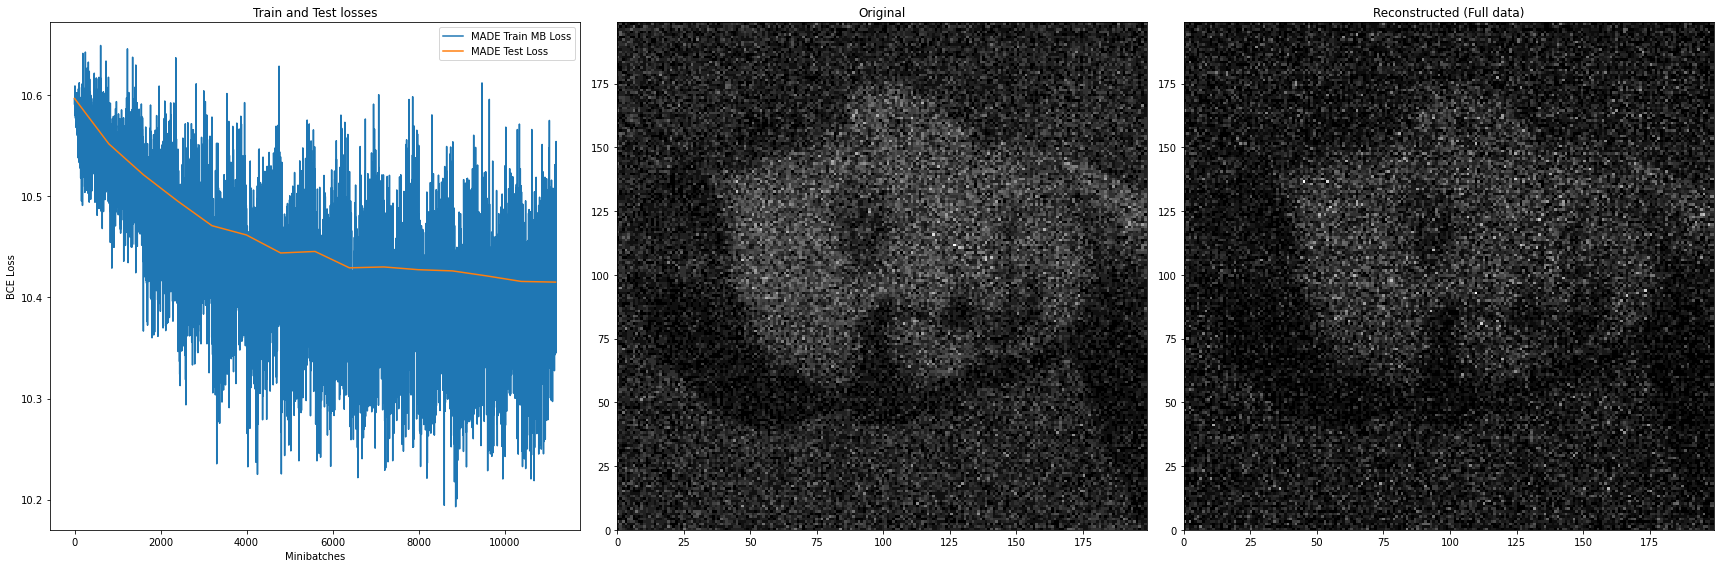

Epoch 14 (Last MB Loss)
	 Train Loss : 10.4024 , Test Loss: 10.4164


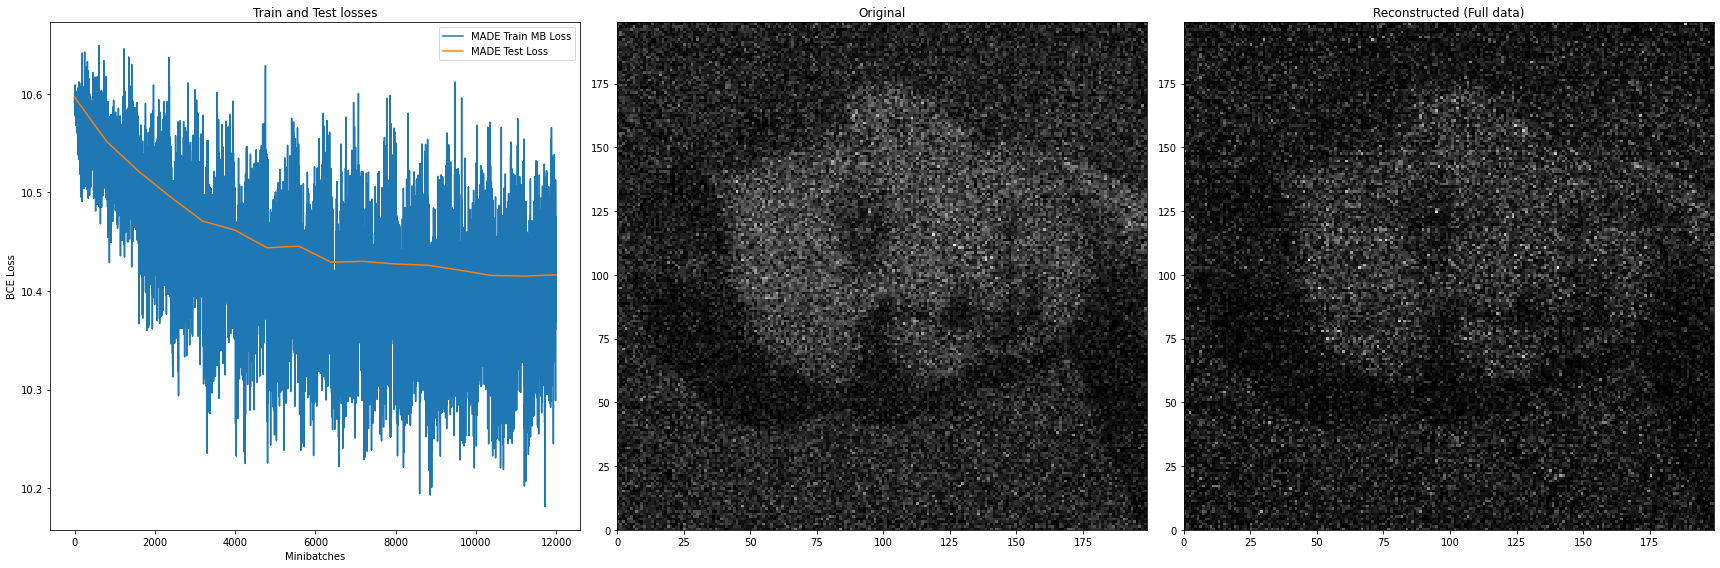

Epoch 15 (Last MB Loss)
	 Train Loss : 10.5429 , Test Loss: 10.4160


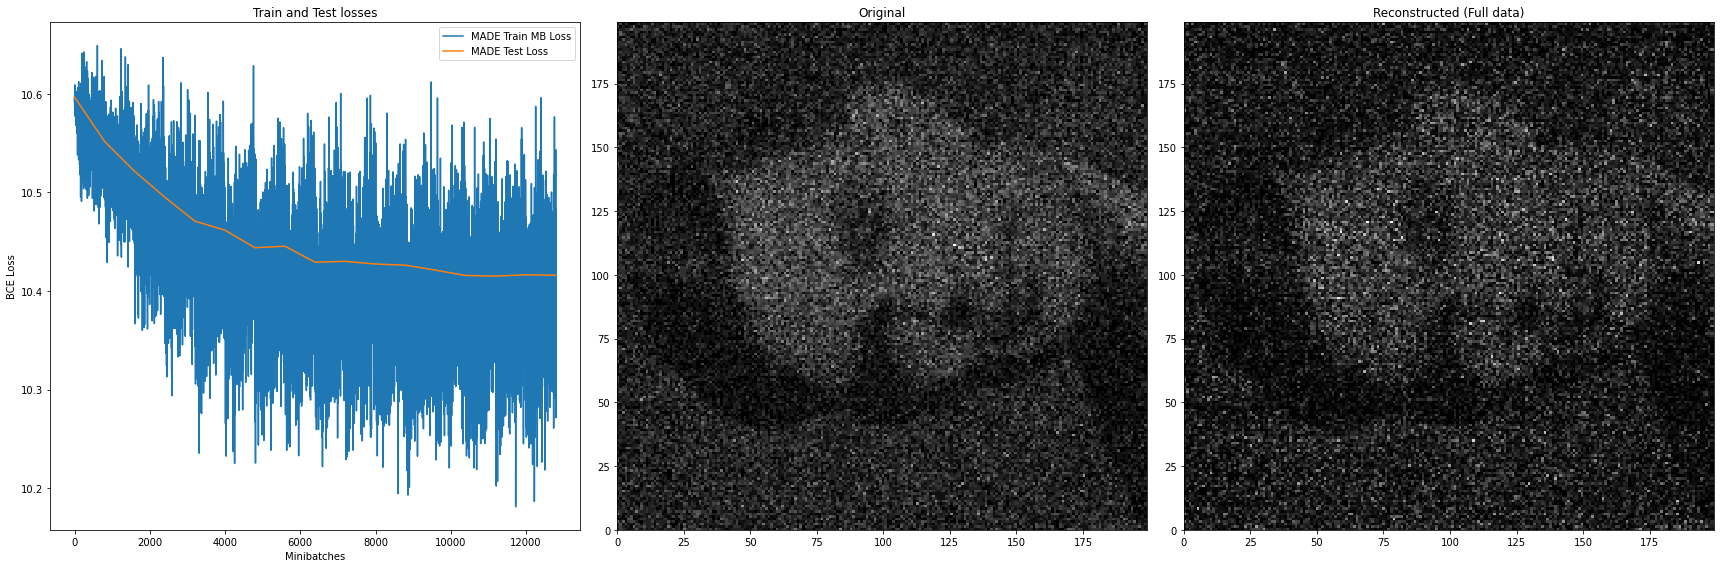

Epoch 16 (Last MB Loss)
	 Train Loss : 10.4939 , Test Loss: 10.4110


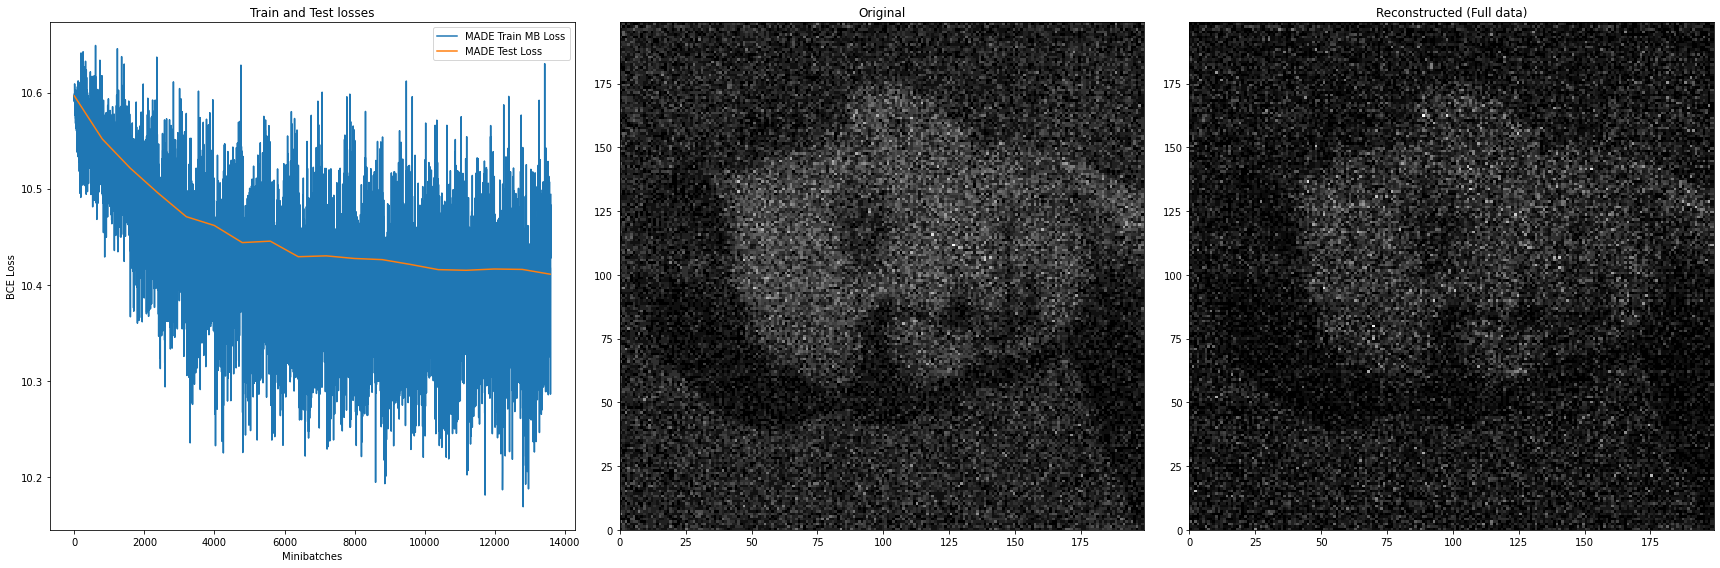

Epoch 17 (Last MB Loss)
	 Train Loss : 10.4018 , Test Loss: 10.4087


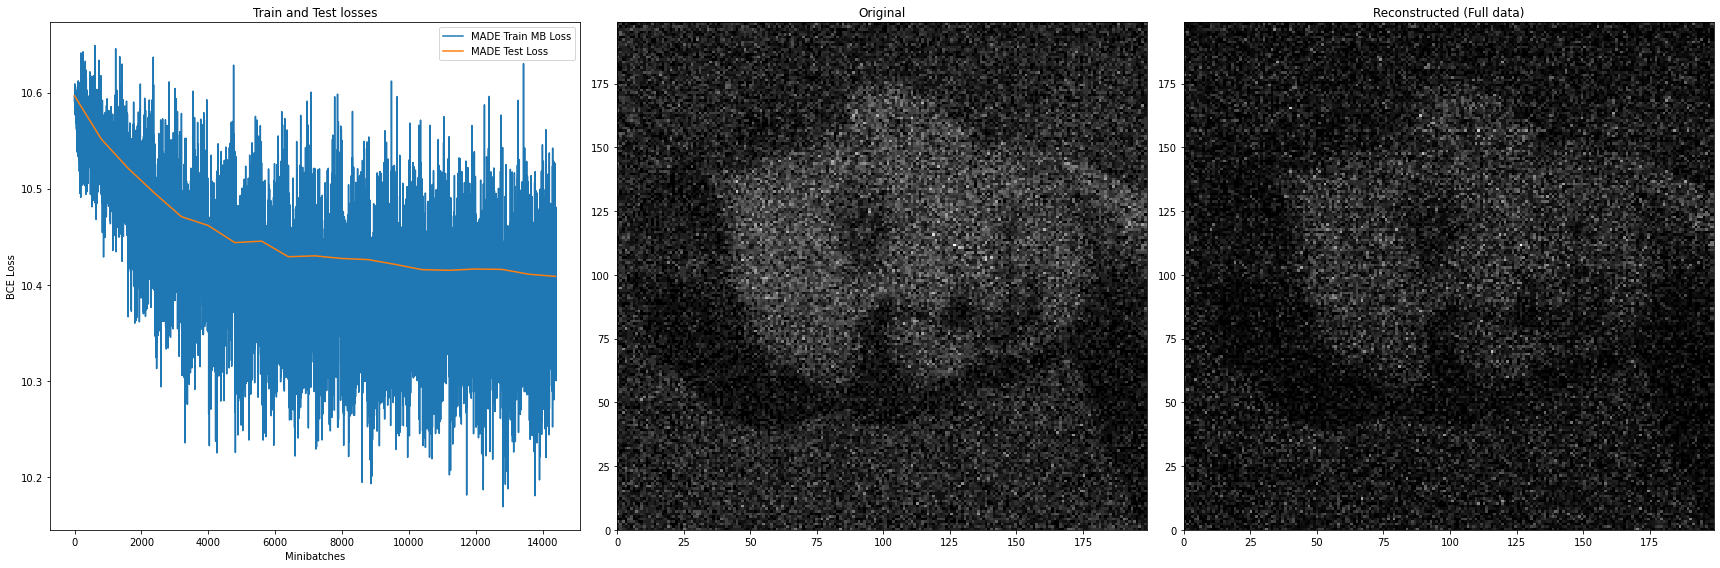

Epoch 18 (Last MB Loss)
	 Train Loss : 10.3862 , Test Loss: 10.4048


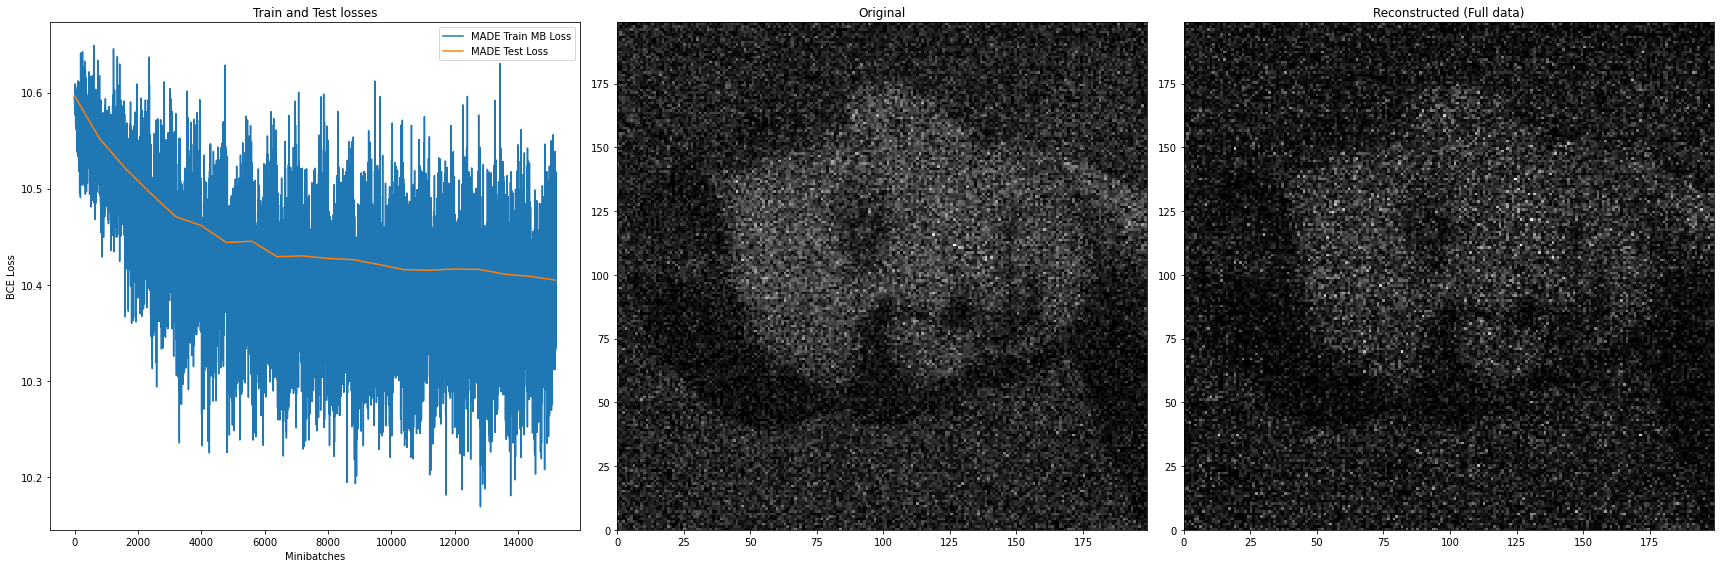

Epoch 19 (Last MB Loss)
	 Train Loss : 10.4923 , Test Loss: 10.4041


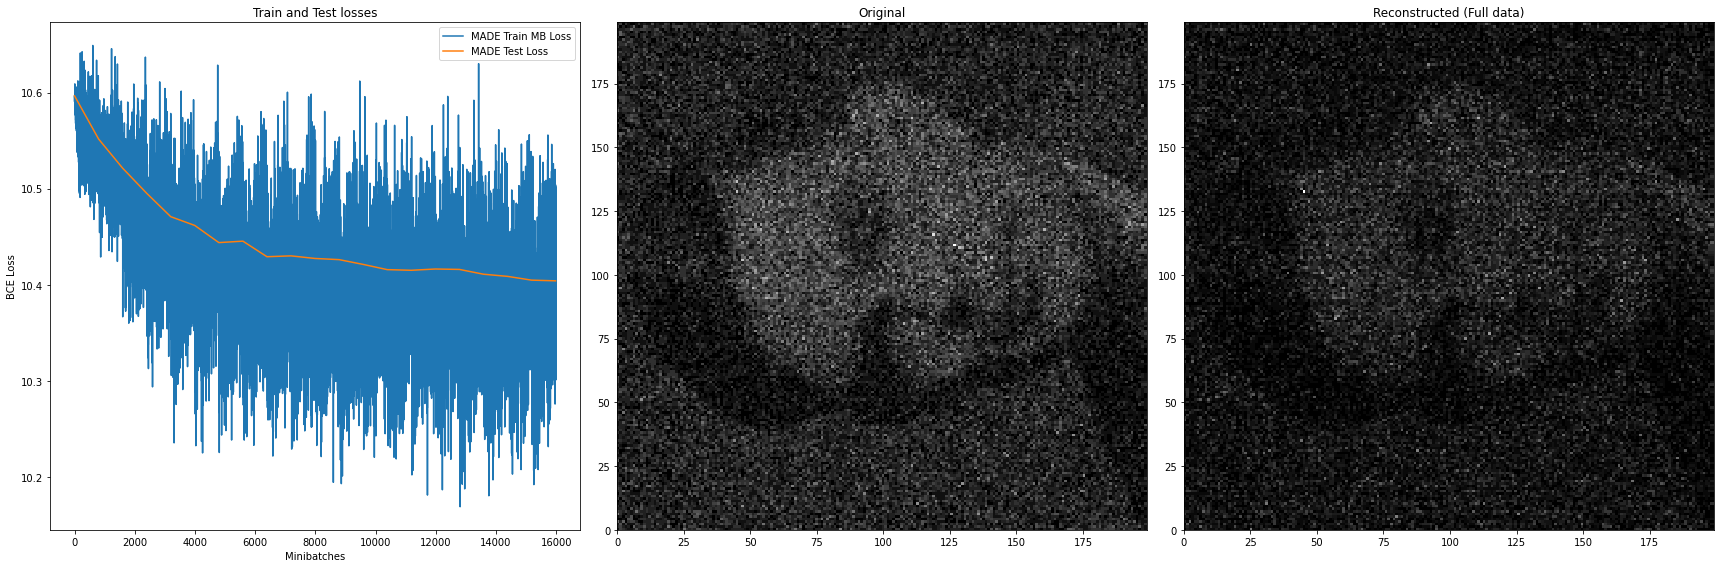

In [8]:
# Training loop
batch_iter = 0 # Used as a reference to regenerate masks
mb_train_losses = []
test_losses = []

test_loss = compute_test_loss( encdec, testset)
test_losses.append( test_loss.item())

# for epoch in range( n_epochs):
for epoch in range( N_EPOCHS):
    
    # Iterate over minibatches
    for mb_idx, mb_train_data in enumerate(trainset):
        # Normalizing the input, so Binary Cross Ent will be more correct
        # mb_train_data = (mb_train_data.float() / 200.).to(device)
        
        # Slight preprocessing on the data.
        mb_train_data = mb_train_data.to(device)
        
        # Train the MADE model
        mb_train_loss, z = compute_loss(encdec, mb_train_data)
        
        # Update the MADE model
        optimiza.zero_grad()
        mb_train_loss.backward() 
        optimiza.step()
        
        mb_train_losses.append(mb_train_loss.item())
        
        batch_iter += 1
        if batch_iter % RESAMPLE_INTERVAL == 0:
            encdec.generate_masks()
            
    # Compute the test /validation loss over the full test batch only at the epoch's end.
    test_loss = compute_test_loss( encdec, testset)
    test_losses.append( test_loss.item())

    print( "Epoch %d (Last MB Loss)" % (epoch))
    print( "\t Train Loss : %.4f , Test Loss: %.4f" %( mb_train_loss, test_loss))
    
    if (epoch > 0 and epoch % 1 == 0) or epoch == (N_EPOCHS -1):
        # Deliverable 1. Train and test losses so far.
        fig, axes = plt.subplots(1, 3,figsize=(24,8))

        x_mbs_train = np.arange(len(mb_train_losses))
        # TODO: use n_minibatch-1 instead of mb_idx
        x_mbs_test = np.arange(0, len(mb_train_losses), mb_idx) # Test loss at the end of each epoch needs to account for gap in minibatch

        # Ploting train and test losses
        axes[0].plot(x_mbs_train, mb_train_losses,label="MADE Train MB Loss")
        axes[0].plot(x_mbs_test, test_losses,label="MADE Test Loss")
        axes[0].set_xlabel("Minibatches")
        axes[0].set_ylabel("BCE Loss")
        axes[0].set_title("Train and Test losses")
        axes[0].legend()
        
        # Deliverable 2. but as the training progresses
        # Plotting sampled points and original on the left
        axes[1].hist2d( full_data[:,0], full_data[:,1], bins=(200,200), cmap='gist_gray')
        axes[1].set_title('Original')
        
        # Sampling from the MADE and reconstructing the data
        with th.no_grad():
            ## Get P_\theta(x_1) and sample from it
            dummy_input = th.zeros([1, INPUT_DIM * N_CLASSES]).to(device)
            x1s_pred, _ = encdec(dummy_input)
            x1_estimate_samples = Categorical(logits=x1s_pred).sample([len(full_data)]).squeeze()
            x1_estimate_samples_hot = F.one_hot(x1_estimate_samples, N_CLASSES).float()
            x1_estimate_samples_hot = th.cat([x1_estimate_samples_hot,
                th.zeros([x1_estimate_samples_hot.shape[0], N_CLASSES]).to(device)], 1) # Adds the expected x2 one hot

            # Get P(x_2|x_1) and sample the corresponding x2 to comple the pairs
            _, x2s_pred = encdec(x1_estimate_samples_hot)

            x2_dist = Categorical(logits=x2s_pred)
            x2_estimate_samples = x2_dist.sample() # Dimension deduced from x1s estiamted sample shape ! So nice of pytorch

        # Type fix
        x1_estimate_samples = x1_estimate_samples.cpu().numpy()
        x2_estimate_samples = x2_estimate_samples.cpu().numpy()
        
        axes[2].hist2d( x1_estimate_samples, x2_estimate_samples, bins=(200,200), cmap='gist_gray')
        axes[2].set_title('Reconstructed (Full data)')
        axes[2].set_xlim(0, 199)
        axes[2].set_ylim(0, 199)
        
        fig.tight_layout()
        plt.show()
    
    # Shuffle the data in a K-folding style, but without the K.
    if SHUFFLE_DATA:
        trainset, test_batch = shuffle_dataset()